##      PONCE_SALAFRANCA GENDER PREDICTION PRETRAINED WITH CELEBA

## D. Gender Classification
Automatic gender classification has been used in many applications. The goal of this project is to classify
the gender of faces in an image. One can design a convolutional neural network or Transformer to achieve
this goal. Some tasks to consider:
1. Modify some previously published architectures e.g., increase the network depth, reducing their
parameters, etc. Explore more advanced techniques such as deformable convolution, dilated
convolution (dilation>1) or visual prompt tuning for Transformers.
2. Consider age and gender recognition simultaneously to take advantage of the gender-specific age
characteristics and age-specific gender characteristics inherent to images
3. Consider pre-training using the CelebA dataset
http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html


References
1. G. Levi and T. Hassner, “Age and gender classification using convolutional neural networks.” in
IEEE Conf. on Computer Vision and Pattern Recognition (CVPR) workshops, 2015
2. Z. Liu and P. Luo and X. Wang, and X. Tang, “Deep learning face attributes in the wild,” in
International Conference on Computer Vision (ICCV), 2015

### 1.0 Import the required packages

In [5]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
import pylab as pl
import seaborn as sns
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.model_selection import KFold

import cv2
import random
from PIL import Image
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img, load_img
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, GlobalMaxPooling2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import optimizers
from tensorflow import keras

import os
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential,load_model,save_model
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.utils import np_utils

import tensorflow as tf
print(tf.__version__)

2.16.1


### 1.1 Pretraining with CelebA

In [6]:
print(os.listdir('./Anno'))

['identity_CelebA.txt', 'list_attr_celeba.txt', 'list_bbox_celeba.txt', 'list_landmarks_align_celeba.txt', 'list_landmarks_celeba.txt']


We import the data set 

In [7]:
data = []
with open('./Anno/list_attr_celeba.txt', 'r') as file:
    lines = file.readlines()[1:]

    # Iterating for each line
    for line in lines:
        # Dividing the line
        columns = line.split()
        
        # Agrega las columnas a la lista de datos
        data.append(columns)

datacols = ["image"]+data[0]

data = data[1:]
f = pd.DataFrame(data, columns = datacols)

In [9]:
data = []
with open('./Eval/list_eval_partition.txt', 'r') as file:
    lines = file.readlines()
    for line in lines:
        columns = line.split()
        
        # We add the data 
        data.append(columns)
datacols = ['image', 'set']
f2 = pd.DataFrame(data, columns = datacols)


CelebA data set is way bigger that our training data. The pretrained data is usually much bigger than the training data. In this case the data is to big to processed by our computers that is way we only take one forth of the data. We use the partition already given by the creators of the data set. Only one forth of the data set has 4 times more instances that the training set.

In [10]:
y = pd.DataFrame({'image':f['image'],'gender':f['Male'], 'set':f2['set']})
half_length = len(y) // 4  # Calcula la mitad de la longitud del DataFrame
y_reduced = y.sample(n=half_length, random_state=42)
gender_to_label_map = {
    '-1' : 0,
    '1' : 1
}

y_reduced['gender'] = y_reduced['gender'].apply(lambda age: gender_to_label_map[age])
y_reduced.head()

,image,gender,set
93241,093242.jpg,1,0
121413,121414.jpg,0,0
10624,010625.jpg,1,0
82523,082524.jpg,0,0
73192,073193.jpg,0,0


In [11]:
img_path = []
for row in y_reduced.iterrows():
    a = row[1].image
    path = f"./data_faces/img_align_celeba/{a}"
    img_path.append(path)


In [12]:
y_reduced['image'] = img_path

We check that the is no NAs

In [13]:
y.isna().sum()

image     0
gender    0
set       0
dtype: int64

## 1.1.1 Divide the data sets

As we have been doing we split the data sets in training testing and validation

In [14]:
Xtrain= pd.DataFrame(y_reduced.loc[y_reduced['set'] == '0', 'image'])
Xvalidation = pd.DataFrame(y_reduced.loc[y_reduced['set'] == '1', 'image'])
Xtest = pd.DataFrame(y_reduced.loc[y_reduced['set'] == '2', 'image'])
ytrain = y_reduced.loc[y_reduced['set'] == '0', 'gender']
yvalidation = y_reduced.loc[y_reduced['set'] == '1', 'gender']
ytest = y_reduced.loc[y_reduced['set'] == '2', 'gender']
print('Training set length',len(Xtrain))
print('Validation set length',len(Xvalidation))
print('Testing set length',len(Xtest))

Training set length 40584
Validation set length 5086
Testing set length 4979


We import the imges using 200x200. We have been using 227x227 but now we want to see that a similar accuracy can be achieved by reducing the imported data.

In [11]:
train_images = []
test_images = []
validation_images = []
count = 0
for row in Xtrain.iterrows():
    image = Image.open(row[1].image)
    image = image.resize((200, 200))   # Resize the image
    data = np.asarray(image)
    # TODO: np.float
    train_images.append(data)

for row in Xtest.iterrows():
    image = Image.open(row[1].image)
    image = image.resize((200, 200))  # Resize the image
    data = np.asarray(image)
    test_images.append(data)
    
for row in Xvalidation.iterrows():
    image = Image.open(row[1].image)
    image = image.resize((200, 200))  # Resize the image
    data = np.asarray(image)
    validation_images.append(data)

train_images = np.asarray(train_images)
test_images = np.asarray(test_images)
validation_images = np.asarray(validation_images)

print('Train images shape {}'.format(train_images.shape))
print('Test images shape {}'.format(test_images.shape))
print('Validation images shape {}'.format(validation_images.shape))

Train images shape (40584, 200, 200, 3)
Test images shape (4979, 200, 200, 3)
Validation images shape (5086, 200, 200, 3)


### 1.3 Creation of the model

We use the same parameters than the optimal gender model.

In [12]:
batch_size = 5
epochs = 20
target_size = (200, 200) 
input_shape = (200, 200, 3) 

# We set random seed, so that our results can be reproducted
SEED = 10
np.random.seed(SEED)
tf.random.set_seed(SEED)

adam = 0.001
fre = -20
FC = 2048
E = 1
factor = 0.50
min_lr = 0.0001
steps_per_epoch = 256
validation_steps = 256

In [13]:
import math
def step_decay(epoch):
    init_learning_rate, drop, epochs_drop = 0.001, 0.1, 10000
    learning_rate = init_learning_rate * math.pow(drop, math.floor((1 + epoch)/epochs_drop))
    return learning_rate
weight_init = keras.initializers.TruncatedNormal(mean = 0.0, stddev = 0.01, seed = SEED)



In [14]:
patience = 3
verbose = 1
def get_call_backs():
    lrate = keras.callbacks.LearningRateScheduler(step_decay)
    mcp = ModelCheckpoint('model.keras')
    es = EarlyStopping(verbose = verbose, patience = patience)
    
    return [lrate, mcp, es]

In [15]:
def build_adience_gender_optimal():
    # Initialize the model as sequential 
    model = keras.models.Sequential()
    
    # First convolution in 2D: 96 filters of size 7 x 7 kernel and ReLu activation function
    # Max pooling with 3 x 3 kernel
    model.add(Conv2D(96, (7, 7), input_shape = input_shape, strides = 4, padding = 'valid', 
                     activation = 'relu', kernel_initializer = weight_init))
    model.add(MaxPool2D(pool_size = (3, 3), strides = 2, padding = 'same'))
    model.add(keras.layers.Lambda(lambda x: tf.nn.local_response_normalization(input = x, alpha = 0.0001, beta = 0.75)))
    
    # Second convolution in 2D: 256 filters of size 5 x 5 kernel and ReLu activation function
    # Max pooling with 3 x 3 kernel
    model.add(Conv2D(256, (5, 5), padding = 'same', activation = 'relu', kernel_initializer = weight_init))
    model.add(MaxPool2D(pool_size = (3, 3), strides = 2, padding = 'same'))
    model.add(keras.layers.Lambda(lambda x: tf.nn.local_response_normalization(input = x, alpha = 0.0001, beta = 0.75)))
    
    # Third convolution in 3D: 384 filters of size 3x3 kernel and ReLu activation function
    # Max pooling with 3 x 3 kernel
    model.add(keras.layers.Conv2D(384, (3, 3), padding = 'same', activation = 'relu', kernel_initializer = weight_init))
    model.add(keras.layers.MaxPool2D(pool_size = (3, 3), strides = 2, padding = 'same'))
    
    # We flatten the model 
    model.add(Flatten())
    
    # First connected layer, receives as input the last convolutional layer
    # ReLu activation function
    model.add(Dense(512, activation = "relu", kernel_initializer = weight_init))
    # Dropout value of 50%, e.g. setting neurons output to 0
    model.add(Dropout(0.5))
    
    # Second connected layer, receives as input the previous layer
    # ReLu activation function
    model.add(Dense(512, activation = 'relu', kernel_initializer = weight_init))
    # Dropout value of 50%, e.g. setting neurons output to 0
    model.add(Dropout(0.5))
    
    # Third connected layer that maps the gender classification
    # Sigmoid activation function
    model.add(Dense(1, activation ='sigmoid', kernel_initializer = weight_init))
    
    # Lastly, we connect to a softmax layer that assigns a probability to each class (male or female)
    # We set the loss fucntion to a cross entropy and the valdiation metric to accuracy
    model.compile(optimizer = keras.optimizers.SGD(learning_rate = 1e-3, momentum = 0.0),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

    return model

In [16]:
model = build_adience_gender_optimal()

C:\Users\jaime\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


### 1.4 Pretraining the model with CelebA

In [17]:
history = model.fit(
    train_images, ytrain, 
    batch_size = batch_size, 
    epochs = 20, 
    validation_data = (validation_images, yvalidation), 
    callbacks=get_call_backs())

Epoch 1/20
8117/8117 ━━━━━━━━━━━━━━━━━━━━ 892s 110ms/step - accuracy: 0.6799 - loss: 0.5791 - val_accuracy: 0.8694 - val_loss: 0.2955 - learning_rate: 0.0010
Epoch 2/20
8117/8117 ━━━━━━━━━━━━━━━━━━━━ 886s 109ms/step - accuracy: 0.8837 - loss: 0.2753 - val_accuracy: 0.9571 - val_loss: 0.1216 - learning_rate: 0.0010
Epoch 3/20
8117/8117 ━━━━━━━━━━━━━━━━━━━━ 884s 109ms/step - accuracy: 0.9455 - loss: 0.1401 - val_accuracy: 0.9556 - val_loss: 0.1095 - learning_rate: 0.0010
Epoch 4/20
8117/8117 ━━━━━━━━━━━━━━━━━━━━ 885s 109ms/step - accuracy: 0.9566 - loss: 0.1079 - val_accuracy: 0.9678 - val_loss: 0.0900 - learning_rate: 0.0010
Epoch 5/20
8117/8117 ━━━━━━━━━━━━━━━━━━━━ 888s 109ms/step - accuracy: 0.9658 - loss: 0.0888 - val_accuracy: 0.9681 - val_loss: 0.0904 - learning_rate: 0.0010
Epoch 6/20
8117/8117 ━━━━━━━━━━━━━━━━━━━━ 889s 110ms/step - accuracy: 0.9727 - loss: 0.0742 - val_accuracy: 0.9650 - val_loss: 0.0961 - learning_rate: 0.0010
Epoch 7/20
8117/8117 ━━━━━━━━━━━━━━━━━━━━ 894s 110ms

### 1.5 Importing the training set 

In [15]:
ADIENCE_PATH = './Adience'
all_folds={}
for i in range(5):
    all_folds[i]=pd.read_csv(os.path.join(ADIENCE_PATH, f'fold_{i}_data.txt'),sep = "\t" )
total_data = pd.concat([all_folds[i] for i in range(5)],ignore_index=True)

In [16]:
total_data

,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score
0,30601258@N03,10399646885_67c7d20df9_o.jpg,1,"(25, 32)",f,0,414,1086,1383,-115,30,17
1,30601258@N03,10424815813_e94629b1ec_o.jpg,2,"(25, 32)",m,301,105,640,641,0,0,94
2,30601258@N03,10437979845_5985be4b26_o.jpg,1,"(25, 32)",f,2395,876,771,771,175,-30,74
3,30601258@N03,10437979845_5985be4b26_o.jpg,3,"(25, 32)",m,752,1255,484,485,180,0,47
4,30601258@N03,11816644924_075c3d8d59_o.jpg,2,"(25, 32)",m,175,80,769,768,-75,0,34
...,...,...,...,...,...,...,...,...,...,...,...,...
19365,7153718@N04,11598838386_349a0d4849_o.jpg,2282,None,NaN,596,460,1472,1473,-75,0,30
19366,7153718@N04,11598166203_c70bb34c80_o.jpg,2283,None,NaN,1179,755,331,331,5,0,108
19367,7153718@N04,11598166203_c70bb34c80_o.jpg,2282,None,NaN,1201,1179,293,293,5,0,99
19368,7153718@N04,11598145163_733cb99713_o.jpg,2282,None,NaN,1027,946,408,408,-85,0,49


In [17]:
df = total_data[['age', 'gender']].copy()
img_path = []

for row in total_data.iterrows():
    path = f"{ADIENCE_PATH}/faces/"+row[1].user_id+"/coarse_tilt_aligned_face."+str(row[1].face_id)+"."+row[1].original_image
    img_path.append(path)
df['img_path'] = img_path

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19370 entries, 0 to 19369
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   age       19370 non-null  object
 1   gender    18591 non-null  object
 2   img_path  19370 non-null  object
dtypes: object(3)
memory usage: 454.1+ KB


In [24]:
age_mapping = [('(0, 2)', '0-2'), ('2', '0-2'), ('3', '3-6'), 
               ('(4, 6)', '3-6'), ('(8, 12)', '8-23'), ('13', '8-23'),
               ('22', '8-23'), ('(8, 23)','8-23'), ('23', '8-23'),
               ('(15, 20)', '8-23'), ('(25, 32)', '25-32'),
               ('(27, 32)', '25-32'), ('32', '25-32'), ('34', '38-48'),
               ('29', '25-32'), ('(38, 42)', '38-48'), ('35', '38-48'),
               ('36', '38-48'), ('42', '38-48'), ('45', '38-48'), 
               ('(38, 43)', '38-48'), ('(38, 42)', '38-48'),
               ('(38, 48)', '38-48'), ('46', '38-48'), ('(48, 53)', '48-53'),
               ('55', '54-59'), ('56', '54-59'), ('(60, 100)', '60+'), ('57', '60+'), ('58', '60+')]

age_mapping_dict = {each[0]: each[1] for each in age_mapping}
drop_labels = []
for idx, each in enumerate(df.age):
    if each == 'None':
        drop_labels.append(idx)
    else:
        df.age.loc[idx] = age_mapping_dict[each]

df = df.drop(labels=drop_labels, axis=0) #droped None values
df.age.value_counts(dropna=False)

C:\Users\jaime\AppData\Local\Temp\ipykernel_22360\3376238852.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.age.loc[idx] = age_mapping_dict[each]


25-32    5095
8-23     4180
38-48    2889
0-2      2491
3-6      2158
60+       901
48-53     830
54-59      78
Name: age, dtype: int64

In [25]:
df = df.dropna()
df = df[df.gender != 'u'].copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17452 entries, 0 to 19345
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   age       17452 non-null  object
 1   gender    17452 non-null  object
 2   x         17452 non-null  int64 
 3   y         17452 non-null  int64 
 4   dx        17452 non-null  int64 
 5   dy        17452 non-null  int64 
 6   img_path  17452 non-null  object
dtypes: int64(4), object(3)
memory usage: 1.1+ MB


In [26]:
gender_to_label_map = {'f' : 0,'m' : 1}

age_to_label_map = {
    '0-2'  :0,
    '3-6'  :1,
    '8-23' :2,
    '25-32':3,
    '38-48':4,
    '48-53':5,
    '54-59':6,
    '60+'  :7
}

# label_to_age_map = {value: key for key, value in age_to_label_map.items()}
# label_to_gender_map = {value: key for key, value in gender_to_label_map.items()}

df['age'] = df['age'].apply(lambda age: age_to_label_map[age])
df['gender'] = df['gender'].apply(lambda g: gender_to_label_map[g])

df.head()

,age,gender,x,y,dx,dy,img_path
0,3,0,0,414,1086,1383,./Adience/faces/30601258@N03/coarse_tilt_align...
1,3,1,301,105,640,641,./Adience/faces/30601258@N03/coarse_tilt_align...
2,3,0,2395,876,771,771,./Adience/faces/30601258@N03/coarse_tilt_align...
3,3,1,752,1255,484,485,./Adience/faces/30601258@N03/coarse_tilt_align...
4,3,1,175,80,769,768,./Adience/faces/30601258@N03/coarse_tilt_align...


In [27]:
X = df[['img_path']]
y = df[['gender']]

from sklearn.model_selection import train_test_split

Xtrain, X_temp, ytrain, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
Xvalidation, Xtest, yvalidation, ytest = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print('Train data shape {}'.format(Xtrain.shape))
print('Validation data shape{}'.format(Xvalidation.shape))
print('Test data shape {}'.format(Xtest.shape))

Train data shape (12216, 1)
Validation data shape(2618, 1)
Test data shape (2618, 1)


In [30]:
train_images = []
test_images = []
validation_images = []

for row in Xtrain.iterrows():
    image = Image.open(row[1].img_path)
    image = image.resize((200, 200))   # Resize the image
    data = np.asarray(image)
    # TODO: np.float
    train_images.append(data)

for row in Xtest.iterrows():
    image = Image.open(row[1].img_path)
    image = image.resize((200, 200))  # Resize the image
    data = np.asarray(image)
    test_images.append(data)
    
for row in Xvalidation.iterrows():
    image = Image.open(row[1].img_path)
    image = image.resize((200, 200))  # Resize the image
    data = np.asarray(image)
    validation_images.append(data)

train_images = np.asarray(train_images)
test_images = np.asarray(test_images)
validation_images = np.asarray(validation_images)

print('Train images shape {}'.format(train_images.shape))
print('Test images shape {}'.format(test_images.shape))
print('Validation images shape {}'.format(validation_images.shape))

Train images shape (12216, 200, 200, 3)
Test images shape (2618, 200, 200, 3)
Validation images shape (2618, 200, 200, 3)


### 1.6 Training the model

We use the same model to train it now with the data of the training set

In [31]:
history_10 = model.fit(
    train_images, ytrain, 
    batch_size = 5, 
    epochs = 100, 
    validation_data = (validation_images, yvalidation), 
    callbacks=get_call_backs())

Epoch 1/100
2444/2444 ━━━━━━━━━━━━━━━━━━━━ 250s 102ms/step - accuracy: 0.7917 - loss: 0.4408 - val_accuracy: 0.8701 - val_loss: 0.2872 - learning_rate: 0.0010
Epoch 2/100
2444/2444 ━━━━━━━━━━━━━━━━━━━━ 263s 108ms/step - accuracy: 0.8756 - loss: 0.2891 - val_accuracy: 0.8862 - val_loss: 0.2603 - learning_rate: 0.0010
Epoch 3/100
2444/2444 ━━━━━━━━━━━━━━━━━━━━ 262s 107ms/step - accuracy: 0.9159 - loss: 0.2180 - val_accuracy: 0.8934 - val_loss: 0.2507 - learning_rate: 0.0010
Epoch 4/100
2444/2444 ━━━━━━━━━━━━━━━━━━━━ 260s 106ms/step - accuracy: 0.9339 - loss: 0.1692 - val_accuracy: 0.8938 - val_loss: 0.2565 - learning_rate: 0.0010
Epoch 5/100
2444/2444 ━━━━━━━━━━━━━━━━━━━━ 263s 107ms/step - accuracy: 0.9491 - loss: 0.1313 - val_accuracy: 0.8942 - val_loss: 0.2832 - learning_rate: 0.0010
Epoch 6/100
2444/2444 ━━━━━━━━━━━━━━━━━━━━ 262s 107ms/step - accuracy: 0.9616 - loss: 0.1088 - val_accuracy: 0.8549 - val_loss: 0.3713 - learning_rate: 0.0010
Epoch 6: early stopping


### 1.7 Testing the model and plotting accuracies

In [45]:
test_loss, test_acc = model.evaluate(test_images, ytest, verbose=2)
print(test_acc)

82/82 - 8s - 103ms/step - accuracy: 0.8655 - loss: 0.3790
0.8655462265014648


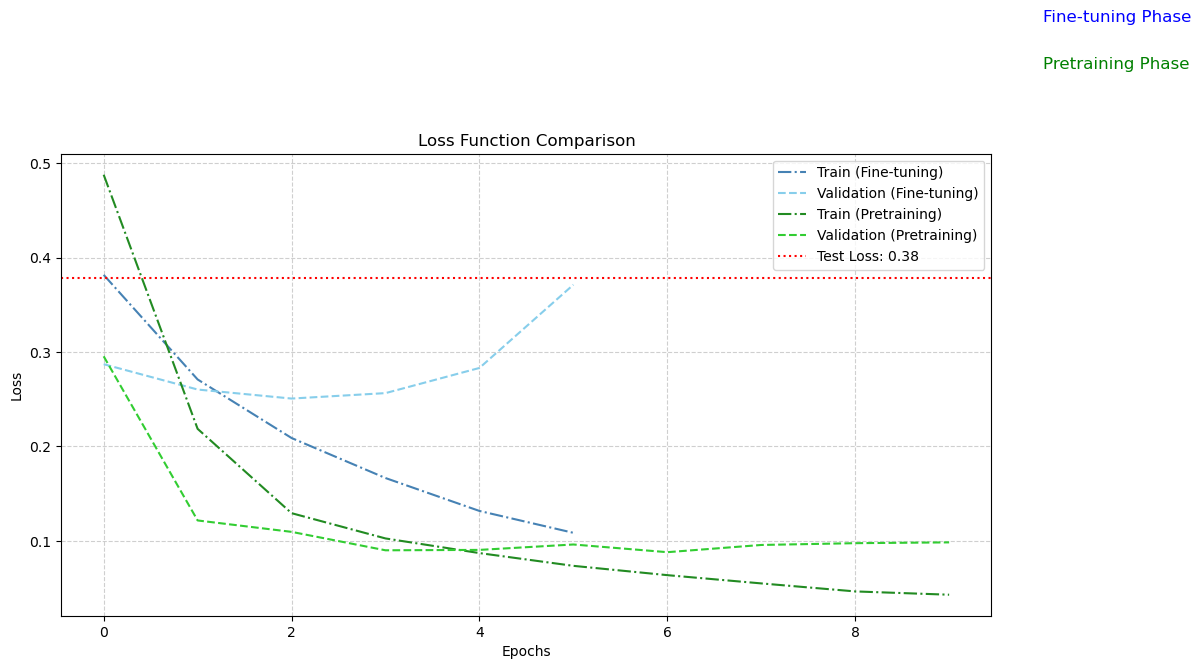

In [54]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(12, 6))

# Plotting training loss (fine-tuning)
plt.plot(history_10.history['loss'], label='Train (Fine-tuning)', color='steelblue', linestyle='-.')

# Plotting validation loss (fine-tuning)
plt.plot(history_10.history['val_loss'], label='Validation (Fine-tuning)', color='skyblue', linestyle='--')

# Plotting training loss (pretraining)
plt.plot(history.history['loss'], label='Train (Pretraining)', color='forestgreen', linestyle='-.')

# Plotting validation loss (pretraining)
plt.plot(history.history['val_loss'], label='Validation (Pretraining)', color='limegreen', linestyle='--')
plt.axhline(y=test_loss, color='red', linestyle=':', label=f'Test Loss: {test_loss:.2f}')

# Adding legend
plt.legend()

# Adding titles and labels
plt.title('Loss Function Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Adding grid
plt.grid(True, linestyle='--', alpha=0.6)

# Adding annotations
plt.text(10, 0.6, 'Pretraining Phase', fontsize=12, color='green')
plt.text(10, 0.65, 'Fine-tuning Phase', fontsize=12, color='blue')

# Show plot
plt.show()


<module 'matplotlib.pyplot' from 'C:\\Users\\jaime\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

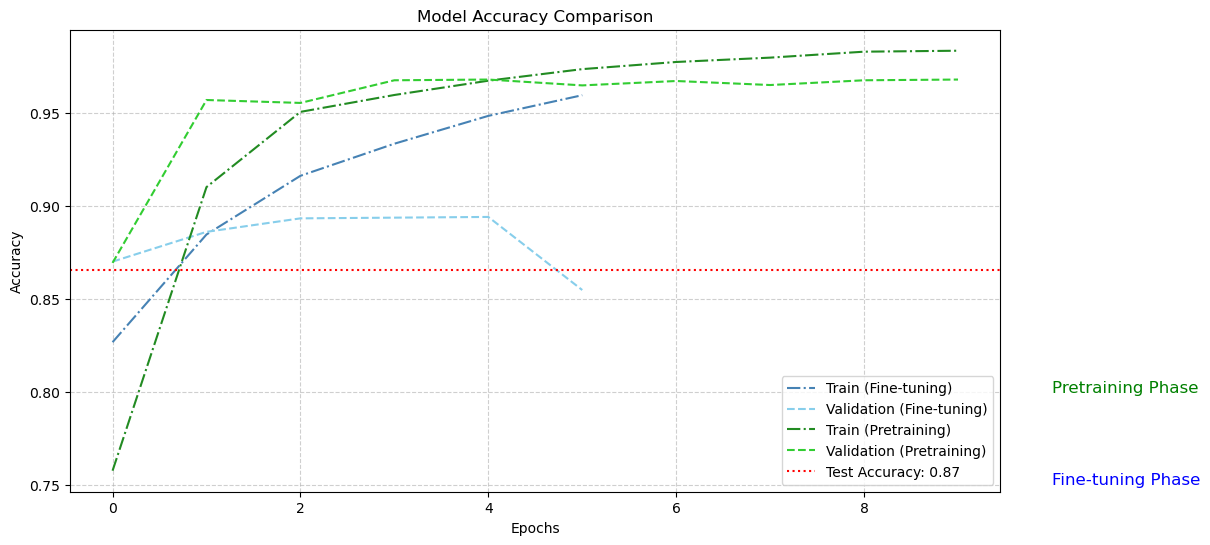

In [52]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(12, 6))

# Plotting training accuracy (fine-tuning)
plt.plot(history_10.history['accuracy'], label='Train (Fine-tuning)', color='steelblue', linestyle='-.')

# Plotting validation accuracy (fine-tuning)
plt.plot(history_10.history['val_accuracy'], label='Validation (Fine-tuning)', color='skyblue', linestyle='--')

# Plotting training accuracy (pretraining)
plt.plot(history.history['accuracy'], label='Train (Pretraining)', color='forestgreen', linestyle='-.')

# Plotting validation accuracy (pretraining)
plt.plot(history.history['val_accuracy'], label='Validation (Pretraining)', color='limegreen', linestyle='--')
plt.axhline(y=test_acc, color='red', linestyle=':', label=f'Test Accuracy: {test_acc:.2f}')
# Adding legend
plt.legend()

# Adding titles and labels
plt.title('Model Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Adding grid
plt.grid(True, linestyle='--', alpha=0.6)

# Adding annotations
plt.text(10, 0.8, 'Pretraining Phase', fontsize=12, color='green')
plt.text(10, 0.75, 'Fine-tuning Phase', fontsize=12, color='blue')
plt


### 1.8 Visualization of some error and non-errors.

We can see some errors and understand in some of them how could the model be wrong.

In [74]:
predictions = model.predict(test_images)

82/82 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step


In [128]:
predictions = np.where(predictions < 0.5, 0, 1)


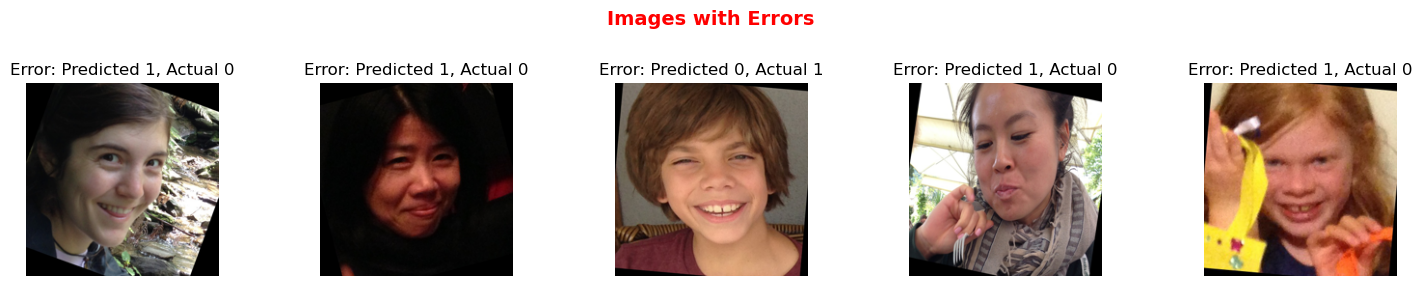

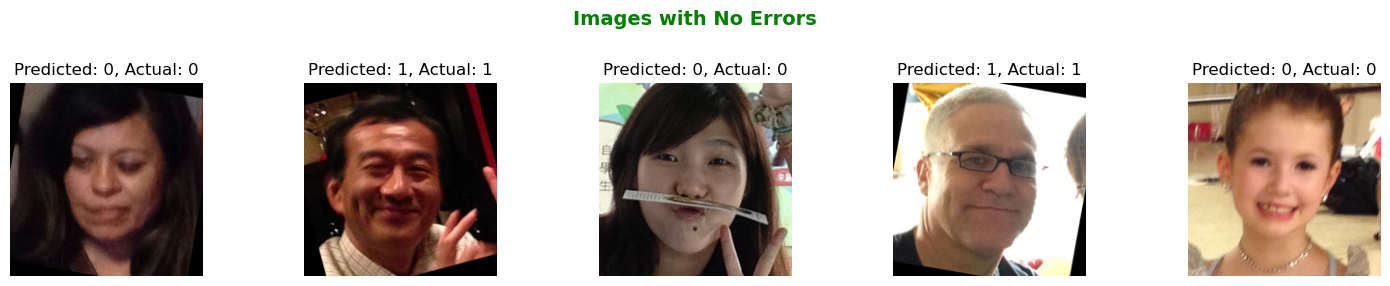

In [125]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming test_images and ytest are your test data and labels
# Applying threshold of 0.5 for binary classification
actual_labels = ytest
# Find indices where predictions match actual labels (no errors)
correct_indices = np.where(predictions == ytest)[0]

# Find indices where predictions do not match actual labels (errors)
error_indices = np.where(predictions != actual_labels)[0]

random_correct_indices = np.random.choice(correct_indices, 3, replace=False)
random_error_indices = np.random.choice(error_indices, 3, replace=False)

# Plotting images with errors
plt.figure(figsize=(15, 3))
for i, idx in enumerate(error_indices[:5]):
    plt.subplot(1, 5, i + 1)
    plt.imshow(test_images[idx], cmap='gray')  # Assuming grayscale images
    plt.title(f'Error: Predicted {int(predictions[idx])}, Actual {ytest.iloc[idx][0]}', fontsize=12)
    plt.axis('off')
plt.suptitle('Images with Errors', fontsize=14, fontweight='bold', color='red')
plt.tight_layout(pad=2.0)
plt.show()

# Plotting images with no errors
plt.figure(figsize=(15, 3))
for i, idx in enumerate(correct_indices[:5]):
    plt.subplot(1, 5, i + 1)
    plt.imshow(test_images[idx], cmap='gray')  # Assuming grayscale images
    plt.title(f'Predicted: {int(predictions[idx])}, Actual: {ytest.iloc[idx][0]}', fontsize=12)
    plt.axis('off')
plt.suptitle('Images with No Errors', fontsize=14, fontweight='bold', color='green')
plt.tight_layout(pad=2.0)
plt.show()
